In [1]:
import os

if not os.getcwd().endswith('mob2crime'):
    os.chdir('..')
os.getcwd()

'/home/Jiahui/mob2crime'

In [2]:
import glob
import urllib.request
import unicodedata
import os
import time
import pandas as pd
import geopandas as gp
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
from shapely.ops import cascaded_union
import src.utils.map_vis as mvis

# 2010 census
https://www.inegi.org.mx/programas/ccpv/2010/default.html

## Marco geoestadístico

In [4]:
folder = 'data/mexico/geography-socioeconomics/2010CensusGeography'

### National Geostatistical Framework up to urban AGEB and points of rural localities

Urban localidade polygons and rural ageb points

In [5]:
mge = gp.read_file(f'{folder}/national_macro/mge2010v5_0/estados.shp')

In [6]:
mgm = gp.read_file(f'{folder}/national_macro/mgm2010v5_0/municipios.shp')

In [7]:
mglu = gp.read_file(f'{folder}/national_macro/mglu2010v5_0/poligonos_urbanos.shp')

In [8]:
mglu['loc_id'] = mglu.CVE_ENT+mglu.CVE_MUN+mglu.CVE_LOC

In [9]:
mglu.head()

,CVE_ENT,CVE_MUN,CVE_LOC,NOM_LOC,geometry,loc_id
0,09,012,0027,San Miguel Topilejo,"POLYGON ((2799930.0009 802316.5907999985, 2799...",090120027
1,09,010,0001,Álvaro Obregón,"POLYGON ((2794395.921300001 824857.5522999987,...",090100001
2,09,012,0026,San Miguel Ajusco,"POLYGON ((2795564.199900001 805128.9651000015,...",090120026
3,09,012,0019,Parres (El Guarda),"POLYGON ((2796031.678199999 795559.3674000017,...",090120019
4,09,013,0001,Xochimilco,(POLYGON ((2803142.855099998 803850.4123000018...,090130001


In [10]:
mglr = gp.read_file(f'{folder}/national_macro/mglr2010v5_0/localidades_rurales.shp')
mglr['loc_id'] = mglr.CVE_ENT +mglr.CVE_MUN+mglr.CVE_LOC
mglr['ageb_id'] = mglr.CVE_ENT +mglr.CVE_MUN+mglr.CVE_LOC + mglr.CVE_AGEB

In [11]:
mglr.geometry.apply(lambda x: x.type).unique()

array(['Point'], dtype=object)

In [12]:
mglr[mglr.CVE_ENT=='01'].head()

,CVE_ENT,CVE_MUN,CVE_AGEB,CVE_LOC,NOM_LOC,geometry,loc_id,ageb_id
185716,01,001,106-8,0094,Granja Adelita,POINT (2461579.763943349 1095060.813845353),010010094,010010094106-8
185717,01,001,175-9,0096,Agua Azul,POINT (2463239.900243366 1096403.128981486),010010096,010010096175-9
185718,01,001,175-9,0100,Rancho Alegre,POINT (2461660.447791724 1093132.58397706),010010100,010010100175-9
185719,01,001,112-3,0102,Los Arbolitos [Rancho],POINT (2463239.954425412 1084957.286524462),010010102,010010102112-3
185720,01,001,190-3,0104,Ardillas de Abajo (Las Ardillas),POINT (2480243.672014353 1103103.167053489),010010104,010010104190-3


In [13]:
mglr.groupby('CVE_LOC').CVE_AGEB.size()

CVE_LOC
0001       4
0002    1574
0003    1507
0004    1451
0005    1409
0006    1315
0007    1325
0008    1276
0009    1267
0010    1228
0011    1208
0012    1204
0013    1129
0014    1129
0015    1078
0016    1061
0017    1028
0018    1027
0019    1023
0020    1021
0021     992
0022     945
0023     962
0024     961
0025     904
0026     919
0027     890
0028     887
0029     864
0030     845
        ... 
5069       1
5070       1
5072       1
5073       1
5075       1
5076       1
5078       1
5079       1
5081       1
5084       1
5085       1
7001       3
7002       1
7003       2
7005       1
7008       1
7015       1
7016       1
7019       1
7201       1
7202       2
7204       1
7301       1
7328       1
7612       1
7901       1
7902       1
8001       1
8009       1
8010       1
Name: CVE_AGEB, Length: 4601, dtype: int64

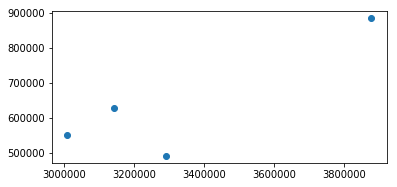

In [14]:
mglr[mglr.CVE_LOC=='0001'].plot()

### Urban Geostatistical Cartography

- link: https://www.inegi.org.mx/app/mapas/?t=0710000000000000&tg=3604
- coverage: 
    - Graphical representation of all the towns with more than 2,500 inhabitants, in addition to the municipal headwaters of the country, existing at the time of the realization of the different census events since 1990, contains street names, location of the main services, the limits of areas Basic urban geostatistics, with their respective identification keys.
    - The set of Urban Localities of the National Territory is constituted by 4,525 localities, corresponding to the closing of the Population and Housing Census 2010, the consultation or download that is provided is for each municipality containing all the localities that conform it.

#### The AGEB within a localidad is almost the same as the whole urban localidad, sometimes it can be large

In [15]:
mglu['mun_id'] = mglu.loc_id.apply(lambda x: x[:5])

In [16]:
mun_ids = mglu.mun_id.unique()

In [78]:
diff_areas = []
for mun_id in mun_ids:
    urb_mun = mglu[mglu.mun_id==mun_id].to_crs(4326).to_crs(mglu.crs)
    urb_ageb = gp.read_file(f'gzip://{folder}/UrbanAgeb/{mun_id}.geojson.gz').to_crs(mglu.crs)
    urb_ageb['ageb'] = urb_ageb.CVEGEO.apply(lambda x: x[-4:])
    urb_ageb['loc_id'] = urb_ageb.CVEGEO.apply(lambda x: x[:-4])

    urb_mza = gp.read_file(f'gzip://{folder}/UrbanMza/{mun_id}.geojson.gz').to_crs(mglu.crs)
    urb_mza['loc_id'] = urb_mza.CVEGEO.apply(lambda x: x[:9])
    urb_mza['ageb'] = urb_mza.CVEGEO.apply(lambda x: x[9:13])
    urb_mza['mza'] = urb_mza.CVEGEO.apply(lambda x: x[13:])
    
    for _, urb_loc in urb_mun.iterrows():
        loc_id = urb_loc.loc_id
        diff = urb_loc.geometry - cascaded_union(urb_ageb[urb_ageb.loc_id==loc_id].geometry.tolist())
        diff_areas.append({'mun_id':mun_id, 'loc_id': loc_id, 'diff': diff})
    
    if len(diff_areas) >= 1257:
        break

In [83]:
diff_areas_df = pd.DataFrame(diff_areas)
diff_areas_df['darea'] = diff_areas_df['diff'].apply(lambda x: x.area)

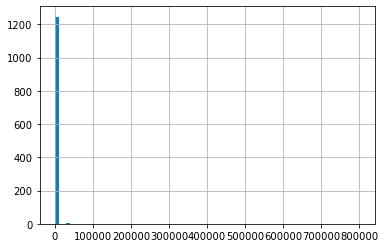

In [105]:
diff_areas_df['darea'].hist(bins=range(-1, 800000, 10000))

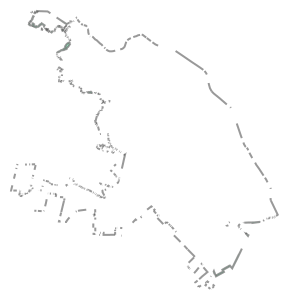

In [90]:
diff_areas_df.loc[1255]['diff']

#### AGEB = MZA + roads + rivers etc

In [18]:
loc_id = '080370001'
mun_id = loc_id[:5]
urb_loc = mglu[mglu.loc_id==loc_id]

urb_ageb = gp.read_file(f'gzip://{folder}/UrbanAgeb/{mun_id}.geojson.gz')
urb_ageb['ageb'] = urb_ageb.CVEGEO.apply(lambda x: x[-4:])
urb_ageb['loc_id'] = urb_ageb.CVEGEO.apply(lambda x: x[:-4])
urb_ageb_loc = urb_ageb[urb_ageb.loc_id==loc_id].to_crs(mglu.crs)

urb_mza = gp.read_file(f'gzip://{folder}/UrbanMza/{mun_id}.geojson.gz')
urb_mza['loc_id'] = urb_mza.CVEGEO.apply(lambda x: x[:9])
urb_mza['ageb'] = urb_mza.CVEGEO.apply(lambda x: x[9:13])
urb_mza['mza'] = urb_mza.CVEGEO.apply(lambda x: x[13:])
urb_mza_loc = urb_mza[urb_mza.loc_id==loc_id].to_crs(mglu.crs)


758354.4955077716


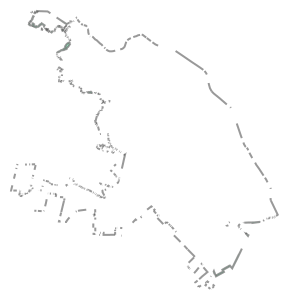

In [93]:
diff = urb_loc.to_crs(epsg=4326).to_crs(mglu.crs).geometry.iloc[0] - cascaded_union(urb_ageb[urb_ageb.loc_id==loc_id].to_crs(mglu.crs).geometry.tolist())
print(diff.area)
diff

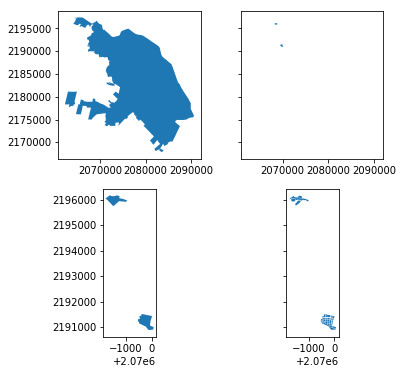

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6,6), sharex='row', sharey='row')
subset = urb_ageb_loc.iloc[:2]
urb_loc.plot(ax=axes[0,0])
subset.plot(ax=axes[1,0])
subset.plot(ax=axes[0,1])
urb_mza_loc[urb_mza_loc.ageb.isin(subset.ageb)].plot(ax=axes[1,1])

### Rural

- Link: https://www.inegi.org.mx/app/mapas/?t=0710000000000000&tg=3595
- coverage: 
    - The Rural Geostatistical Cartography, closing of the Population and Housing Census 2010, is organized in digital archives with alphanumeric and vector information, distributed by federal entities, being understood by locality to any place occupied with one or more buildings used as dwellings, which can be inhabited or not.
    - They contain street names, cultural and natural features (bodies of water), main access roads to the town and the location of the main services (church, school, medical assistance, municipal palace or assistance, market, cemetery and plaza or garden) .
    - The set of Rural Localities of the National Territory is constituted by 48,115 localities, corresponding to the closing of the Population and Housing Census 2010, the consultation or download that is provided is for each municipality containing all the localities that conform it.

#### mglr: point; rural_ageb: polygon, rural_ageb>sum(mza)

In [76]:
loc_id = '140780377'
mun_id = loc_id[:5]

rur_loc_in_mg = mglr[mglr.loc_id==loc_id]

rur_ageb = gp.read_file(f'gzip://{folder}/RuralAgeb/{mun_id}.geojson.gz')
rur_ageb['ageb'] = rur_ageb.CVEGEO.apply(lambda x: x[-4:])
rur_ageb['loc_id'] = rur_ageb.CVEGEO.apply(lambda x: x[:-4])
rur_ageb_loc = rur_ageb[rur_ageb.loc_id==loc_id].to_crs(mglr.crs)

rur_mza = gp.read_file(f'gzip://{folder}/RuralMza/{mun_id}.geojson.gz')
rur_mza['loc_id'] = rur_mza.CVEGEO.apply(lambda x: x[:9])
rur_mza['ageb'] = rur_mza.CVEGEO.apply(lambda x: x[9:13])
rur_mza['mza'] = rur_mza.CVEGEO.apply(lambda x: x[13:])
rur_mza_loc = rur_mza[rur_mza.loc_id==loc_id].to_crs(mglr.crs)


/home/Jiahui/miniconda3/envs/crime-bias/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


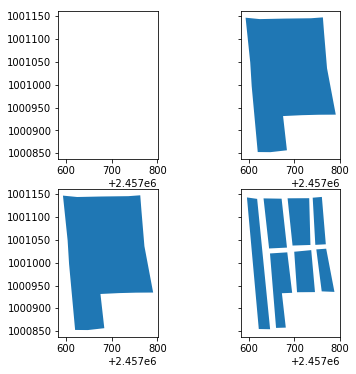

In [77]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6,6), sharex='row', sharey='row')
subset = rur_ageb_loc.iloc[:2]
rur_loc_in_mg.plot(ax=axes[0,0])
subset.plot(ax=axes[1,0])
subset.plot(ax=axes[0,1])
rur_mza_loc[rur_mza_loc.ageb.isin(subset.ageb)].plot(ax=axes[1,1])

#### RuralAgeb: each loc_id has 1 ageb(1 polygon or 1 multipolygon) 

In [17]:
rural_ageb_dir = f'{folder}/RuralAgeb'

In [20]:
mgar = []
stats = []
for fn in glob.glob(rural_ageb_dir + '/*'):
    rur_ageb = gp.read_file('gzip://' + fn)
    rur_ageb['loc_id'] = rur_ageb.CVEGEO.apply(lambda x: x[:-4])
    stats.append({
        'mun_id': fn.split('/')[-1][:5],
        'null_CVEGEO': rur_ageb.CVEGEO.isnull().sum(),
        'nunique_CVEGEO': rur_ageb.CVEGEO.nunique(),
        'nunique_loc_id': rur_ageb.loc_id.nunique(),
        'nrow': len(rur_ageb),
        'ncol': rur_ageb.shape[1],
        **rur_ageb.geometry.apply(lambda x: x.type).value_counts().to_dict()
    })
    mgar.append(rur_ageb)
stats = pd.DataFrame(stats)

In [31]:
# each loc id has 1 ageb
(stats.nunique_loc_id==stats.nrow).mean(), stats.null_CVEGEO.sum()

(1.0, 0)

In [32]:
stats

,MultiPolygon,Polygon,mun_id,ncol,nrow,null_CVEGEO,nunique_CVEGEO,nunique_loc_id
0,NaN,16.0,01006,11,16,0,16,16
1,1.0,17.0,20392,11,18,0,18,18
2,NaN,20.0,30129,11,20,0,20,20
3,2.0,12.0,28023,11,14,0,14,14
4,NaN,1.0,21060,11,1,0,1,1
5,NaN,12.0,21106,11,12,0,12,12
6,NaN,3.0,20546,11,3,0,3,3
7,5.0,12.0,13081,11,17,0,17,17
8,NaN,2.0,31089,11,2,0,2,2
9,NaN,10.0,26052,11,10,0,10,10


In [23]:
mgar = pd.concat(mgar, ignore_index=True)

/home/Jiahui/miniconda3/envs/crime-bias/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


#### ageb_rur has TIPOLOC==URBANA, but their loc_id are all in mglr

In [79]:
mglr[mglr.loc_id.apply(lambda x: x.startswith('09'))]

,CVE_ENT,CVE_MUN,CVE_AGEB,CVE_LOC,NOM_LOC,geometry,loc_id,ageb_id
178689,09,004,015-7,0010,Cruz Blanca,POINT (2780493.521578416 816062.0936183166),090040010,090040010015-7
178690,09,004,015-7,0050,La Venta,POINT (2781798.451096746 817895.9507391807),090040050,090040050015-7
178691,09,004,015-7,0054,Puerto las Cruces (Monte las Cruces),POINT (2777949.048141876 813530.62081136),090040054,090040054015-7
178692,09,004,015-7,0055,Teopazulco,POINT (2780348.426506351 819156.8819083124),090040055,090040055015-7
178693,09,004,015-7,0057,Prolongación Constitución,POINT (2780075.100359336 819765.1370507888),090040057,090040057015-7
178694,09,004,015-7,0058,Paraje Río Borracho,POINT (2779901.653145797 819700.5700905882),090040058,090040058015-7
178695,09,004,015-7,0060,La Bolsa (El Encinal),POINT (2782693.691388946 818280.7865491584),090040060,090040060015-7
178696,09,004,015-7,0062,Rancho los Campesinos,POINT (2778340.128019953 814427.2695160285),090040062,090040062015-7
178697,09,004,015-7,0063,Santa Rosa,POINT (2783306.927169103 816636.24066622),090040063,090040063015-7
178698,09,004,015-7,0066,Rancho Santa Laura,POINT (2780733.594200069 818796.0600547642),090040066,090040066015-7


In [78]:
mgar[mgar.loc_id.apply(lambda x: x.startswith('09'))]

,CODIGO,CVEGEO,FECHAACT,GEOGRAFICO,GEOMETRIA,INSTITUCIO,NOMLOC,OID,TIPOLOC,geometry,id,loc_id
8789,LA_6770,0900800830368,06/2011,LOCALIDAD,ÁREA,INEGI,El Gavillero,NaN,RURAL,POLYGON ((-99.24707135484014 19.28452587772129...,0,090080083
8790,LA_6770,0900800880368,06/2011,LOCALIDAD,ÁREA,INEGI,Totolapa,NaN,RURAL,POLYGON ((-99.24586255642875 19.28037761435702...,1,090080088
9549,LA_6770,0900400500157,06/2011,LOCALIDAD,ÁREA,INEGI,La Venta,NaN,RURAL,POLYGON ((-99.31143388289408 19.33360725131416...,0,090040050
9550,LA_6770,0900400540157,06/2011,LOCALIDAD,ÁREA,INEGI,Puerto las Cruces (Monte las Cruces),NaN,RURAL,POLYGON ((-99.34753555594702 19.29753344033636...,1,090040054
9551,LA_6770,0900400630157,06/2011,LOCALIDAD,ÁREA,INEGI,Santa Rosa,NaN,RURAL,POLYGON ((-99.29532299753932 19.32285882822804...,2,090040063
9552,LA_6770,0900400700335,06/2011,LOCALIDAD,ÁREA,INEGI,Punta Galicia,NaN,RURAL,POLYGON ((-99.30147539009782 19.37714091088943...,3,090040070
9553,LA_6770,0900400100157,06/2011,LOCALIDAD,ÁREA,INEGI,Cruz Blanca,NaN,RURAL,POLYGON ((-99.32118494808402 19.31930785570109...,4,090040010
19756,LA_6770,0901301980902,06/2011,LOCALIDAD,ÁREA,INEGI,Calle de Sinatlixpa,NaN,RURAL,POLYGON ((-99.10979955194858 19.19936283996776...,0,090130198
19757,LA_6770,0901302020635,06/2011,LOCALIDAD,ÁREA,INEGI,Paraje Zacapa,NaN,RURAL,"POLYGON ((-99.0911836024528 19.21941785232287,...",1,090130202
19758,LA_6770,0901302310635,06/2011,LOCALIDAD,ÁREA,INEGI,Tecanco,NaN,RURAL,POLYGON ((-99.07282770521579 19.23139134563447...,2,090130231


In [80]:
mgar.shape

(48071, 12)

In [35]:
mgar.TIPOLOC.value_counts()

RURAL     46689
URBANA     1382
Name: TIPOLOC, dtype: int64

In [48]:
mgar_loc_id_urb = set(mgar[mgar.TIPOLOC=="URBANA"].loc_id)

In [49]:
mgar_loc_id_rur = set(mgar[mgar.TIPOLOC=="RURAL"].loc_id)

In [51]:
# no overlap in loc_id
mgar_loc_id_urb & mgar_loc_id_rur

set()

In [52]:
loc_id_mglu = set(mglu.loc_id)
loc_id_mglr = set(mglr.loc_id)

In [56]:
# all urb loc id is in mglr
mgar_loc_id_urb & loc_id_mglr == mgar_loc_id_urb

True

#### most rur_loc has point repr, some of them has polygons in rur_ageb, 224 has polygons but not population


In [82]:
folder_census = 'data/mexico/geography-socioeconomics/2010Census/'
pop_mglr = pd.read_csv(f'{folder_census}/rural_loc_pop.csv.gz',
                       dtype={'entidad': str, 'mun': str, 'loc': str, 'mza': str}, index_col=0)
pop_mglr['loc_id'] = pop_mglr.entidad + pop_mglr.mun + pop_mglr['loc']

In [95]:
pop_mglr_loc_id = set(pop_mglr.loc_id)
mglr_loc_id = set(mglr.loc_id)
mgar_loc_id = set(mgar.loc_id)

In [101]:
mglr_loc_id == pop_mglr_loc_id

True

In [96]:
in_mglr_not_mgar = mglr_loc_id-mgar_loc_id
len(in_mglr_not_mgar)

139875

In [97]:
in_mgar_not_mglr = mgar_loc_id - mglr_loc_id
len(in_mgar_not_mglr), (in_mgar_not_mglr - loc_id_with_pop) == in_mgar_not_mglr  # these extra loc_ids have no population

(224, True)

In [98]:
in_both = mgar_loc_id & mglr_loc_id
len(in_both)

47847

## add population from  


In [23]:
folder_census = 'data/mexico/geography-socioeconomics/2010Census/'

pop_urb_mza = pd.read_csv(f'{folder_census}/urban_mza_pop.csv.gz',dtype={'entidad': str, 'mun': str, 'loc':str, 'ageb':str, 'mza':str})
pop_urb_mza['mza_id'] = pop_urb_mza.entidad + pop_urb_mza.mun+ pop_urb_mza['loc'] + pop_urb_mza.ageb + pop_urb_mza.mza

pop_urb_ageb = pd.read_csv(f'{folder_census}/urban_ageb_pop.csv',dtype={'entidad': str, 'mun': str, 'loc':str, 'ageb':str, 'mza':str})
pop_urb_ageb['ageb_id'] = pop_urb_ageb.entidad + pop_urb_ageb.mun+ pop_urb_ageb['loc'] + pop_urb_ageb.ageb

pop_urb_loc = pop_urb_ageb.groupby(['entidad', 'mun','loc']).pobtot.sum().reset_index()
pop_urb_loc['loc_id'] = pop_urb_loc.entidad + pop_urb_loc.mun+pop_urb_loc['loc']

In [36]:
mun_id = mun_ids[0]

In [59]:
urb_loc_pop = mglu[mglu.mun_id==mun_id].merge(pop_urb_loc, on='loc_id').to_crs(epsg=4326)
total_pop = urb_loc_pop.pobtot.sum()
max_pop = urb_loc_pop.pobtot.max()
urb_loc_pop['pob_pcnt']= urb_loc_pop.pobtot/total_pop
urb_loc_pop['pob_norm']= urb_loc_pop.pobtot/max_pop


In [61]:

urb_ageb = gp.read_file(f'gzip://{folder}/UrbanAgeb/{mun_id}.geojson.gz')
urb_ageb_pop = urb_ageb.merge(pop_urb_ageb[['ageb_id','pobtot']], left_on='CVEGEO', right_on='ageb_id')
urb_ageb_pop['pob_pcnt']= urb_ageb_pop.pobtot/urb_ageb_pop.pobtot.sum()
urb_ageb_pop['pob_norm']= urb_ageb_pop.pobtot/urb_ageb_pop.pobtot.max()


In [68]:
urb_mza = gp.read_file(f'gzip://{folder}/UrbanMza/{mun_id}.geojson.gz')
urb_mza_pop = urb_mza.merge(pop_urb_mza[['mza_id','pobtot']], left_on='CVEGEO', right_on='mza_id')
urb_mza_pop['pob_pcnt']= urb_mza_pop.pobtot/urb_mza_pop.pobtot.sum()
urb_mza_pop['pob_norm']= urb_mza_pop.pobtot/urb_mza_pop.pobtot.max()


In [33]:
import folium

In [72]:
folder_census

'data/mexico/geography-socioeconomics/2010Census/'

In [73]:
# plot the vor polygons in cities
m = folium.Map(location=[19.381495, -99.139095], zoom_start=8)

mvis.geojson_per_row_color_col(urb_loc_pop, 'loc', color_col='pob_norm', tip_cols=['loc_id','pobtot', 'pob_pcnt', 'pob_norm'],some_map=m)
mvis.geojson_per_row_color_col(urb_ageb_pop, 'ageb', color_col='pob_norm', tip_cols=['ageb_id','pobtot', 'pob_pcnt', 'pob_norm'],some_map=m)
mvis.geojson_per_row_color_col(urb_mza_pop, 'mza', color_col='pob_norm', tip_cols=['mza_id','pobtot', 'pob_pcnt', 'pob_norm'],some_map=m)

folium.LayerControl().add_to(m)
m.save(folder_census+'20190926Pop_diff_lvl.html')